## Algoritmo Truly PPO: CartPole
#### TFG: Aprendizaje por refuerzo: fundamentos teóricos del algoritmo PPO e implementación
#### Autor: Alberto Maurel

En este Notebook se implementa el algoritmo PPO para el problema Pong, siguiendo las indicaciones de la memoria. 

En primer lugar se crea la función `preprocess_image`, que se encargará de preprocesar los fotogramas del Pong para adaptarlos a nuestras redes neuronales.

In [1]:
import time
import cv2
import numpy as np
import random


def preprocess_image(image):
    preprocessed_image = [[0 for _ in range(0,160)] for _ in range(0, 210)]
    
    #Collapse the data 
    for i in range(0, 210):
        for j in range(0, 160): 
            preprocessed_image[i][j] = max([image[i][j][0], image[i][j][1], image[i][j][2]])
            
    #Reduce its size
    reduced_image = [[0 for _ in range(0,80)] for _ in range(0, 105)]
    max_pixel = 0
    for i in range(0, 105):
        for j in range(0, 80):
            reduced_image[i][j] = (preprocessed_image[2*i][2*j] + preprocessed_image[2*i+1][2*j] + 
                                        preprocessed_image[2*i][2*j+1] + preprocessed_image[2*i+1][2*j+1])
            max_pixel = max(max_pixel, reduced_image[i][j])
    
    for i in range(0, 105):
        for j in range(0, 80):
            reduced_image[i][j] = reduced_image[i][j]/max_pixel
    
        
    return reduced_image

A continuación, se crea la función `run_simulation`, que se encarga de ejecutar una simulación sobre el entorno utilizando las estimaciones de las redes neuronales `model_val` (valor) y `model_res` (política).

In [2]:
# This code is an implementation of the PPO algorithm, mixing the ideas shown in the paper and on the OpenAI Spinning Up webpage:
#  https://spinningup.openai.com/en/latest/algorithms/ppo.html

import gym 
from gym import envs
import time
import numpy as np
import random
import copy

# run_simulation: Runs a simulation of the chosen environments
# Parameters:
#  model_val: value neural network
#  model_policy: policy neural network

# Returns:
#  observations: list of states the simulation has gone through 
#  rewards: list of rewards obtained
#  values: list of values predicted by the neural network for each state
#  actions: list with the action taken at each step
#  probabilities: list of policies predicted by the neural network for each state
threshold = 0.05
def run_simulation(model_val, model_policy):
    observations = []
    states = []
    rewards = []
    values = []
    actions = []
    probabilities = []
    
    #Create a fresh environment
    env = gym.make('Pong-v0')
    raw_observation = env.reset()
    #210 x 160 x 3
    it = 0
    
    #Iterates until we reach the maximum number of timesteps or our pole is too tilted
    while True:
        raw_observation = list(raw_observation)
        observation = preprocess_image(raw_observation)
        observations.append(observation)
        
        state = np.dstack([observations[max(-4,-len(observations))], observations[max(-3,-len(observations))], 
                           observations[max(-2,-len(observations))], observations[max(-1,-len(observations))]])
        
        states.append(state)
        
        #Uncomment if you want to render the simulation
        #env.render()
        
        #Ask the neural network for the current value and policy:
        value = model_val.predict(np.array([state]))[0][0]
        policy = model_policy.predict(np.array([state]))[0]

        #0 - NOOP
        #2 - UP
        #5 - DOWN
        
        #Choose one of the available actions following the discrete distribution provided
        action = np.random.choice(a=[i for i in range(0,3)], p=policy)
        
        if action == 0: 
            action_t = 0
        elif action == 1: 
            action_t = 2
        else:
            action_t = 5

        #Append the gathered information to the arrays
        values.append(value)
        actions.append(action)
        probabilities.append(policy)
        
        #Once we have decided what action we are going to take, take the step and save the reward
        raw_observation, reward, done, _ = env.step(action_t)
        rewards.append(reward)
        
        
        #Check if the simulation has ended
        if done:
            print('Simulation finished')
            break
        it += 1
        if it % 100 == 0:
            print(it)
            print(policy)
        
    
    env.close()
    
    #Return all the information
    return states, rewards, values, actions, probabilities

Tras esto, creamos las redes neuronales. La red neuronal del valor (`PPONet_Val`) es bastante sencilla:

In [3]:
import tensorflow as tf

#Neural network to predict the value for each state
class PPONet_Val:    

    # build: builds a fresh neural network
    #  Returns:
    #   model: model with the desired architecture
    def build(self):
        inputs = tf.keras.layers.Input(shape = (105,80,4), name="input")
        x = tf.keras.layers.Conv2D(16, (8, 8), input_shape=(105,80,4), strides=(4, 4), padding='same', name="conv_1")(inputs)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same', name="conv_2")(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Dense(1)(x)
          
        model = tf.keras.Model(inputs=inputs, outputs=x, name="ppo_nn_val")
        
        model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0002), loss="mean_squared_error") #, run_eagerly=True)
        return model
    
    
    # load_model: loads a previously saved neural network
    #  Parameters:
    #   path: path to the file the model has been saved into
    #  Returns:
    #   model: neural network
    def load_model(self, path):
        model = self.build()
        model.load_weights(path)
        return model
    
    
    # save_model: saves a trained neural network
    #  Parameters:
    #   model: model to be saved
    #   path: path to the file where we want to save the model    
    def save_model(self, model, path):
        model.save_weights(path)

La red neuronal para la política (`PPONet_Policy`) es bastante más compleja, puesto que incluye la función especial de pérdida. 

In [4]:
eps = 0.05

#Neural network to predict the policy for each state
class PPONet_Policy:    
    
    # build: builds a fresh neural network
    #  Returns:
    #   model: model with the desired architecture
    def build(self):
        inputs = tf.keras.layers.Input(shape = (105,80,4))
        x = tf.keras.layers.Conv2D(16, (8, 8), input_shape=(105,80,4), strides=(4, 4), padding='same')(inputs)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(32, (4, 4), strides=(2, 2), padding='same')(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Dense(3)(x)
        x = tf.keras.layers.Activation('softmax', name="policy_output")(x)
          
        model = tf.keras.Model(inputs=inputs, outputs=x, name="ppo_nn_val")
            
        model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0002), loss=custom_loss)
        return model
    
    
    # load_model: loads a previously saved neural network
    #  Parameters:
    #   path: path to the file the model has been saved into
    #  Returns:
    #   model: neural network
    def load_model(self, path):
        model = self.build()
        model.load_weights(path)
        return model
    
    
    # save_model: saves a trained neural network
    #  Parameters:
    #   model: model to be saved
    #   path: path to the file where we want to save the model 
    def save_model(self, model, path):
        model.save_weights(path)

# custom_loss: Custom loss function, as described in the original paper
# This is not a standard loss function. Usually, we provide the neural network with 2 things: the predicted labels
#  and the original labels. However, here there are no "original" and "predicted" labels, we have just an old policy
#  and a new one. To follow the Tensorflow criteria, y_true will be the old policy (the data we provide as input 
#  during the training) and y_pred will be the new policy (the one we get directly from the neural network as the output of 
#  the given states).
# In addition, to calculate the loss we don't only need both policies but also the actions taken and the calculated 
#  advantage estimators. This adds extra complexity, because the loss function can only handle 2 arguments, and encapsulating
#  the loss function into another function leads to weird Tensorflow optimizing bugs. In addition, the length of both arrays 
#  (y_true and y_pred) has to be the same.

# My solution is to include the actions and advantage estimators in y_true. Imagine we have the following data:
#  old_policy: [[0.7, 0.3], [0.65, 0.35], [0.47, 0.53]]
#  new_policy: [[0.62, 0.38], [0.73, 0.27], [0.52, 0.48]]
#  actions: [1,0,1]
#  advantage estimators: [-1.5, 0.75, -0.25]

# Then, our parameters would be:
#  y_true: [[0.7, 0.3, 1, -1.5], [0.65, 0.35, 0, 0.75], [0.47, 0.53, 1, -0,25]]
#  y_pred: [[0.62, 0.38], [0.73, 0.27], [0.52, 0.48]]
# Although the size of the second dimension is different, there is no problem as the lenght of the first dimension remains the same

#  Returns:
#   loss: calculated loss
def custom_loss(y_true, y_pred):
    
    #Reshape the y_true array (I don't know why the shape is lost during the function call)
    y_true = tf.reshape(y_true, (len(y_true)*5,))

    #We merge the old policy, actions and advantage estimators during the function call. Now, we have to split them
    actions_data = tf.gather(params=y_true, indices=tf.range(start=3, limit=len(y_true), delta=5))
    actions_data = tf.cast(actions_data, dtype=tf.int32)
    
    advantage_estimators_data_trim = tf.gather(params=y_true, indices=tf.range(start=4, limit=len(y_true), delta=5))
    advantage_estimators_data_trim = tf.cast(advantage_estimators_data_trim, dtype=tf.float32)
    
    y_true_0 = tf.gather(params=y_true, indices=tf.range(start=0, limit=len(y_true), delta=5))
    y_true_1 = tf.gather(params=y_true, indices=tf.range(start=1, limit=len(y_true), delta=5))
    y_true_2 = tf.gather(params=y_true, indices=tf.range(start=2, limit=len(y_true), delta=5))
    y_true_trim = tf.stack([y_true_0, y_true_1, y_true_2], axis = 1)
    y_true_trim = tf.cast(y_true_trim, dtype=tf.float32)

    #We provide the neural network with the probability of taking both actions for each state. However, we just need the
    # probability of the selected action
    old_predictions = tf.gather(params=tf.reshape(y_true_trim, [-1]), indices=tf.math.add(tf.range(start=0, limit=3*len(y_true_trim), delta=3), actions_data))
    old_predictions = tf.math.add(old_predictions, tf.fill([len(old_predictions)],1e-8))

    #Same with the new policy
    new_predictions = tf.gather(params=tf.reshape(y_pred, [-1]), indices=tf.math.add(tf.range(start=0, limit=3*len(y_pred), delta=3), actions_data))
    new_predictions = tf.math.add(new_predictions, tf.fill([len(new_predictions)],1e-8))

    #Now, we calculate the r_theta ratios by dividing the new probability and the old one. Instead of dividing (which might 
    # lead to precision issues), we substract the logarithms, and exponentiate again the result.
    r_theta = tf.math.exp(tf.math.subtract(tf.math.log(new_predictions), tf.math.log(old_predictions)))
    
    # a and b are the two terms into the minimum on the loss function, as explained in the original paper. 
    a = tf.math.multiply(r_theta, advantage_estimators_data_trim, name = 'a')
    
    b = tf.math.multiply(tf.clip_by_value(r_theta, 1-eps, 1+eps), advantage_estimators_data_trim, name = 'b')
    
    #Select the minimum
    min_elems = tf.math.minimum(a, b, name = 'min')
    
    #Add all the minimums
    clip = tf.math.reduce_sum(min_elems, name='clip')
    
    #We have to change the sign. The original loss function maximizes the loss function, while Tensorflow always minimize the
    # loss. Due to that, we minimize the opposite of the original loss function, which equals to maximize the original one.
    clip2 = tf.math.multiply(clip, -1)
    
    return clip2

Tras esto, solo queda unir todas las partes del algoritmo. En primer lugar se definen los hiperparámetros, de acuerdo a lo explicado en la memoria.

In [6]:
#HYPERPARAMETERS

#Number of iterations of the PPO algorithm
NUM_ITERATIONS = 1500

#Simulations run each iteration
NUM_ACTORS = 1

gamma = 0.99

#Number of steps the estimator will look ahead
horizon = 128

Este código es el encargado de realizar las simulaciones, calcular los estimadores de ventaja y las recompensas y entrenar los modelos

In [7]:
import time
import copy
import sys

# Load/Create value network
neural_network = PPONet_Val()
model_val = neural_network.build()
#model_val = neural_network.load_model('pong_weights_3/val_it_1494.h5')
    

# Load/Create policy network
neural_network2 = PPONet_Policy()
model_pol = neural_network2.build()
#model_pol = neural_network2.load_model('pong_weights_3/pol_it_1494.h5')

#Iterate the desired amount of iterations
for iter in range(0, NUM_ITERATIONS):
    observations_data = []
    rewards_data = []
    values_data = []
    probabilities_data = []
    advantage_estimators_data = []
    actions_data = []
    values_obtained_data = []
    
    #Gather all the rollouts
    for r in range(0, NUM_ACTORS):
        
        #Run one simulation
        observations, rewards, values, actions, probabilities = run_simulation(model_val, model_pol)
        advantage_estimators = []
        values_obtained = []
        
        #Calculate the rewards
        for i in range(0, len(rewards)):
            val = 0
            for j in range(i, len(rewards)):
                val = val + gamma**(j-i)*rewards[j]
    
            values_obtained.append(val)
        
        #Calculamos los advantage estimators
        for i in range(0,len(rewards)): #Puede que esto sea -1
            adv = -values[i]
            if i + horizon < len(rewards):
                adv = adv + gamma**horizon*values[i+horizon]
            
            for j in range(0, horizon):
                if i + j == len(rewards):
                    break
                adv = adv + gamma**j*rewards[i+j]
                
            advantage_estimators.append(adv)
            
        observations_data.extend(copy.deepcopy(observations))
        rewards_data.extend(copy.deepcopy(rewards))
        values_obtained_data.extend(copy.deepcopy(values_obtained))
        actions_data.extend(copy.deepcopy(actions))
        probabilities_data.extend(copy.deepcopy(probabilities))
        advantage_estimators_data.extend(copy.deepcopy(advantage_estimators))
        
        
    #Update the policy network
    print('average_reward: ', sum(rewards_data)/NUM_ACTORS)
    advantage_estimators_data = np.reshape(np.array(advantage_estimators_data), (-1))
    y_true_np = np.array([np.concatenate([a, [b], [c]]) for a, b, c in zip(probabilities_data, actions_data, advantage_estimators_data)]) 
    print(y_true_np.shape)
    model_pol.fit(x=np.array(observations_data), y=y_true_np, batch_size = 64, epochs = 3, verbose=1)
    print('it: ', iter)
    
    #Update the value network
    model_val.fit(x=np.array(observations_data), y=np.array(values_obtained_data), batch_size = 64, epochs = 3, verbose=1)

    #Save the trained neural networks
    neural_network.save_model(model_val, 'pong_weights_3/val_it_' + str(iter) + '.h5')
    neural_network2.save_model(model_pol, 'pong_weights_3/pol_it_' + str(iter) + '.h5')

C:\Users\alber\Anaconda3\envs\Breakout PPO\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ubyte_scalars


100
[0.28617948 0.38263255 0.33118802]
200
[0.2863385  0.38292965 0.33073184]
300
[0.28528586 0.3835414  0.33117276]
400
[0.29406983 0.38006398 0.32586625]
500
[0.29069376 0.38368323 0.325623  ]
600
[0.28535944 0.38256136 0.33207926]
700
[0.2890244  0.37954536 0.33143032]
800
[0.28503558 0.37925464 0.3357098 ]
900
[0.2869785  0.38461494 0.32840654]
1000
[0.28885224 0.37656647 0.3345813 ]
Simulation finished
average_reward:  -21.0
(1098, 5)
Epoch 1/3
18/18 [==============================] - 0s 27ms/step - loss: 87.4760
Epoch 2/3
18/18 [==============================] - 0s 27ms/step - loss: 86.6088
Epoch 3/3
18/18 [==============================] - 0s 24ms/step - loss: 86.6732
it:  0
Epoch 1/3
18/18 [==============================] - 0s 26ms/step - loss: 0.6775
Epoch 2/3
18/18 [==============================] - 0s 25ms/step - loss: 0.2101
Epoch 3/3
18/18 [==============================] - 0s 25ms/step - loss: 0.1987


Una vez que hemos entrenado el modelo, podemos utilizarlo para pasarnos el entorno modificando la política probabilista por una política determinista, en la que en todo momento se ejecuta la acción con mayor probabilidad. Para ello sustituimos la función `run_simulation` por `run_game`, donde la única diferencia está en cómo se escoge la acción a realizar.

In [8]:
import matplotlib.pyplot as plt

def run_game(model_val, model_policy):
    observations = []
    rewards = []
    values = []
    
    #Create a fresh environment
    env = gym.make('Pong-v0')
    raw_observation = env.reset()
    #210 x 160 x 3
    it = 0
    
    #Iterates until we reach the maximum number of timesteps or our pole is too tilted
    while True:
        raw_observation = list(raw_observation)
        
        #generate the current state preprocessing the image and stacking the last observations
        observation = preprocess_image(raw_observation)
        #print(np.array(observation).shape)
        
        observations.append(observation)
        #print(observation)
        
        state = np.dstack([observations[max(-4,-len(observations))], observations[max(-3,-len(observations))], 
                           observations[max(-2,-len(observations))], observations[max(-1,-len(observations))]])

        #Uncomment if you want to render the simulation
        env.render()
        
        #Ask the neural network for the current value and policy:
        value = model_val.predict(np.array([state]))[0][0]
        values.append(value)
        policy = model_policy.predict(np.array([state]))[0]

        if policy[0] > policy[1] and policy[0] > policy[2]:
            action_t = 0
        elif policy[1] > policy[0] and policy[1] > policy[2]:
            action_t = 2
        else:
            action_t = 5
            
     
        #Once we have decided what action we are going to take, take the step and save the reward
        raw_observation, reward, done, _ = env.step(action_t)
        rewards.append(reward)
        
        #Check if the simulation has ended
        if done:
            print('Simulation finished')
            break
        it += 1
        
        #print(policy)
        #print(value)
        
    
    env.close()
    
    #Return all the information
    return rewards, values

Además de jugar, el siguiente código nos permite ver la recompensa predicha y obtenida

C:\Users\alber\Anaconda3\envs\Breakout PPO\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in ubyte_scalars


Simulation finished


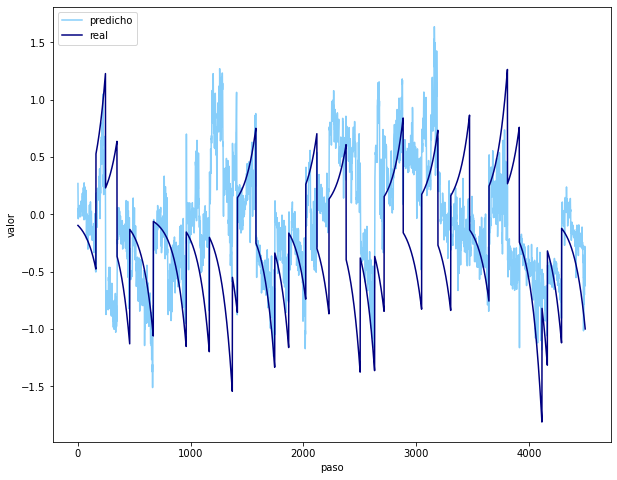

In [9]:
import matplotlib.pyplot as plt

neural_network = PPONet_Val()
model_val = neural_network.load_model('val_it_1500.h5')

neural_network2 = PPONet_Policy()
model_pol = neural_network2.load_model('pol_it_1500.h5')
rewards, values = run_game(model_val,model_pol)


values_obtained = []
#Calculate the rewards
for i in range(0, len(rewards)):
    val = 0
    for j in range(i, len(rewards)):
        val = val + gamma**(j-i)*rewards[j]

    values_obtained.append(val)

axis = [i for i in range(0,len(rewards))]
plt.subplots(figsize=(10,8))
plt.plot(axis, values, color='lightskyblue')
plt.plot(axis, values_obtained, color='navy')
plt.legend(['predicho','real'], loc='upper left')

plt.ylabel('valor')
plt.xlabel('paso')

plt.savefig('pong_val_vs_reward.png')

plt.show()